# Binary Classification

In [10]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from kiwigrad import Value, MLP, Layer
from sklearn.datasets import make_moons, make_blobs
np.random.seed(1337)
random.seed(1337)

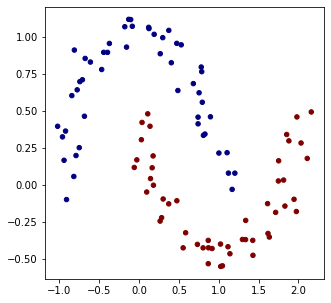

In [11]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [12]:
Xb, yb = X, y
inputs = [list(map(Value, xrow)) for xrow in Xb]

In [13]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=2, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=1, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()

In [14]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(Value(1.0) + Value(-yi)*scorei).relu() for yi, scorei in zip(yb, scores)]
    
    data_loss = sum(losses) * (Value(1.0) / Value(len(losses)))
    # L2 regularization
    alpha = Value(1e-4)
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.181592, grad=0.000000) 0.5


In [15]:
# optimization
for k in range(100):
    s = time.monotonic()
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    e = time.monotonic()
    t = e - s
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%, time: {t:.2f} sec.")

step 0 loss 1.1815924818239036, accuracy 50.0%, time: 0.03 sec.
step 10 loss 0.3176038682804336, accuracy 89.0%, time: 0.02 sec.
step 20 loss 0.22577744378801215, accuracy 92.0%, time: 0.02 sec.
step 30 loss 0.35027887399624996, accuracy 89.0%, time: 0.03 sec.
step 40 loss 0.09745912726682807, accuracy 95.0%, time: 0.03 sec.
step 50 loss 0.05243801242620995, accuracy 99.0%, time: 0.03 sec.
step 60 loss 0.036989018681936464, accuracy 100.0%, time: 0.03 sec.
step 70 loss 0.018699428103430664, accuracy 100.0%, time: 0.02 sec.
step 80 loss 0.016688519606967225, accuracy 100.0%, time: 0.03 sec.
step 90 loss 0.014652049002652004, accuracy 100.0%, time: 0.03 sec.


(-1.548639298268643, 1.951360701731357)

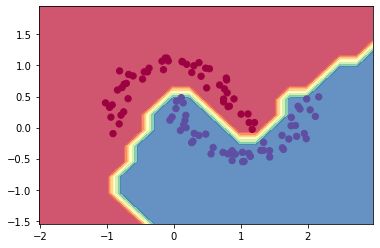

In [16]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())